# 라이브러리

In [2]:
import os

import pandas as pd
import geopy.distance
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

import matplotlib.pyplot as plt
# import matplotlib as plt
plt.rcParams['font.family'] = 'AppleGothic' # window
plt.rcParams['font.size'] = 10 # 글자 크기

import warnings 
warnings.filterwarnings('ignore')

from sklearn.tree import export_graphviz
import pydot

# path = '/content/drive/MyDrive/Colab Notebooks/bootcourse/project/data/'
path = '/Users/minji/Desktop/data/229255_bus_riders_at_rush_hour_data/'

# 0. 데이터 불러오기

In [6]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
bus_bts = pd.read_csv(path + "bus_bts.csv")

train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# 1. 전처리

##1) date 변수 변환
- weekday 추출
- weekday one-hot-encoding

In [7]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [8]:
train['date'] = pd.to_datetime(train['date'])

# weekday 추출
train['weekday'] = train['date'].dt.weekday

# one-hot-encoding
train = pd.get_dummies(train, columns = ['weekday'])

In [9]:
#test도 동일한 전처리 진행
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday
test = pd.get_dummies(test,columns = ['weekday'])

## 2) in_out 변수 변환


In [10]:
#시내인 경우가 월등히 많음
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [11]:
#in_out 변수 one-hot-encoding
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

## 3) 좌표 데이터 feature engineering

dis_jejusi : 버스정류장과 제주시와의 거리

dis_seoquipo : 버스정류장과 서귀포시와의 거리

제주시의 위.경도 : 33.500770, 126.522761

서귀포시의 위.경도 : 33.259429, 126.558217

In [ ]:
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도

test['dis_jeju'] = [geopy.distance.geodesic((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejusi).km for i in range(len(test))]
test['dis_seogwipo'] = [geopy.distance.geodesic((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(test))]

In [ ]:
train['dis_jeju'] = [geopy.distance.geodesic((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seogwipo'] = [geopy.distance.geodesic((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [ ]:
data = train
data.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jeju,dis_seogwipo
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0,0,0,0,0,0,1,2.954920,26.256744
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,5.0,0,0,0,0,0,0,1,3.720275,26.403025
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0,0,0,0,0,0,1,5.036124,25.893305
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,53.0,0,0,0,0,0,0,1,2.864166,27.997494
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0,0,0,0,0,0,1,29.040353,13.574693


## 4) 강수량 추가

In [ ]:
rain = pd.read_csv(path + "rain_jeju_9&10.csv")
rain['date'] = pd.to_datetime(rain['date'])

rain['date'] = rain["date"].dt.strftime("%Y-%m-%d")
rain['date'] = pd.to_datetime(rain['date'])

rain.head()

,date,rain_jeju(mm),rain_seogwipo(mm)
0,2019-09-01,26.1,18.7
1,2019-09-02,25.7,14.6
2,2019-09-03,13.9,9.5
3,2019-09-04,43.0,28.9
4,2019-09-05,7.0,15.7


In [ ]:
train = pd.merge(train,rain)
test = pd.merge(test,rain)

In [ ]:
train.to_csv(path + 'train_final.csv',index = False)
test.to_csv(path + 'test_final.csv',index = False)

## 5) holiday 추가

In [ ]:
# train.drop([], axis=1, inplace=True)

In [3]:
train = pd.read_csv(path + 'train_final.csv')
test = pd.read_csv(path + 'test_final.csv')

In [4]:
def holiday(x):
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        return 0

train['holiday'] = train['date'].apply(holiday) 
test['holiday'] = test['date'].apply(holiday) 

In [5]:
train.isnull().sum()

id                   0
date                 0
bus_route_id         0
in_out               0
station_code         0
station_name         0
latitude             0
longitude            0
6~7_ride             0
7~8_ride             0
8~9_ride             0
9~10_ride            0
10~11_ride           0
11~12_ride           0
6~7_takeoff          0
7~8_takeoff          0
8~9_takeoff          0
9~10_takeoff         0
10~11_takeoff        0
11~12_takeoff        0
18~20_ride           0
weekday_0            0
weekday_1            0
weekday_2            0
weekday_3            0
weekday_4            0
weekday_5            0
weekday_6            0
dis_jeju             0
dis_seogwipo         0
rain_jeju(mm)        0
rain_seogwipo(mm)    0
holiday              0
dtype: int64

In [5]:
test.isnull().sum()

id                   0
date                 0
bus_route_id         0
in_out               0
station_code         0
station_name         0
latitude             0
longitude            0
6~7_ride             0
7~8_ride             0
8~9_ride             0
9~10_ride            0
10~11_ride           0
11~12_ride           0
6~7_takeoff          0
7~8_takeoff          0
8~9_takeoff          0
9~10_takeoff         0
10~11_takeoff        0
11~12_takeoff        0
weekday_0            0
weekday_1            0
weekday_2            0
weekday_3            0
weekday_4            0
weekday_5            0
weekday_6            0
dis_jeju             0
dis_seogwipo         0
rain_jeju(mm)        0
rain_seogwipo(mm)    0
holiday              0
dtype: int64

# 2. 평가 함수
- rmse vs. rmsle
https://ahnjg.tistory.com/90
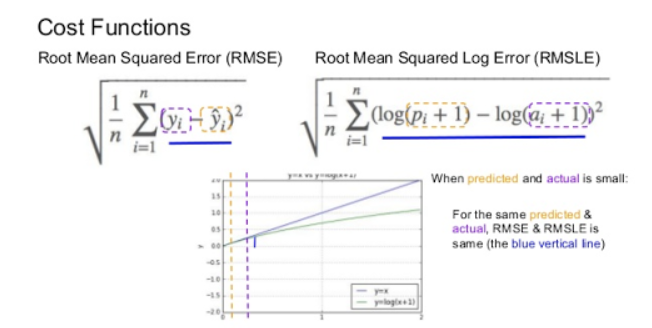

In [6]:
# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
#RMSLE 의 식을 살펴보면, 어떤 양( log(XX) )의 각각을 제곱(square)한 값을 평균(mean)을 내서, 루트(root)를 씌운다.

def rmsle(y, pred, convertExp=True):
    if convertExp:
        y = np.expm1(y)
        pred = np.expm1(pred)
    
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# make_scorer - This factory function wraps scoring functions for use in GridSearchCV and cross_val_score. 
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [10]:
# def rmse(y, pred):
#     squared_error = (y - pred) ** 2
#     rmse = np.sqrt(np.mean(squared_error))
#     return rmse

def rmse(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 3. 모델링

## train-test 분리

In [8]:
# input_var=['latitude','longitude','6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
#        '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
#        '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
#        'weekday_5', 'weekday_6', 'dis_jeju', 'dis_seogwipo']
# target = ['18~20_ride']

In [11]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'dis_jeju', 'dis_seogwipo',
       'rain_jeju(mm)', 'rain_seogwipo(mm)', 'holiday'],
      dtype='object')

In [6]:
train.drop(['date','station_name'], axis=1, inplace=True)

In [7]:
X = train.loc[:, train.columns != '18~20_ride']
y = train[['18~20_ride']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle = False)

## Linear Regression

In [15]:
lin_reg = LinearRegression()

In [16]:
lin_reg.fit(X_train, y_train)

: 

: 

In [ ]:
scores = cross_val_score(lin_reg, X_train, y_train, scoring=rmse_scorer, cv=5)
-scores.mean() # 5개 교차 검증한 결과의 평균 rmse

In [2]:
lin_predict = lin_reg.predict(X_test)

NameError: name 'lin_reg' is not defined

### Linear regression 결과 확인

In [ ]:
plt.scatter(y_test,lin_predict,alpha = 0.4)

### rsquared 값 계산
- 0.44의 결정계수를 가짐. X변수들이 y변수에 미치는 영향이 44%로 X변수들이 '6~8시 승차 인원' 값 변동의 44%를 설명할 수 있음.

In [ ]:
#calculate R-squared of regression model
r_squared = lin_reg.score(X_train, y_train)

#view R-squared value
print(r_squared) 
# 0.4409



## RandomFoerstRegressor

In [12]:
rf = RandomForestRegressor(random_state = 1217)

%time rf.fit(X_train, y_train)

CPU times: user 6min, sys: 2.45 s, total: 6min 3s
Wall time: 6min 9s


RandomForestRegressor(random_state=1217)

In [13]:
scores = cross_val_score(rf, X_train, y_train, scoring=rmse_scorer, cv=5)
-scores.mean() # 5개 교차 검증한 결과의 평균 rmse

### RandomForest 결과 확인

In [13]:
rf_predict = rf.predict(X_test)

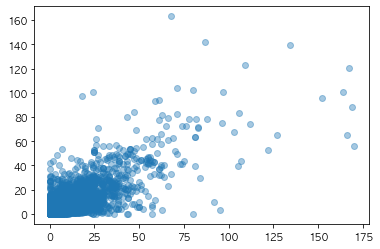

In [11]:
plt.scatter(y_test,rf_predict,alpha = 0.4)

<BarContainer object of 29 artists>

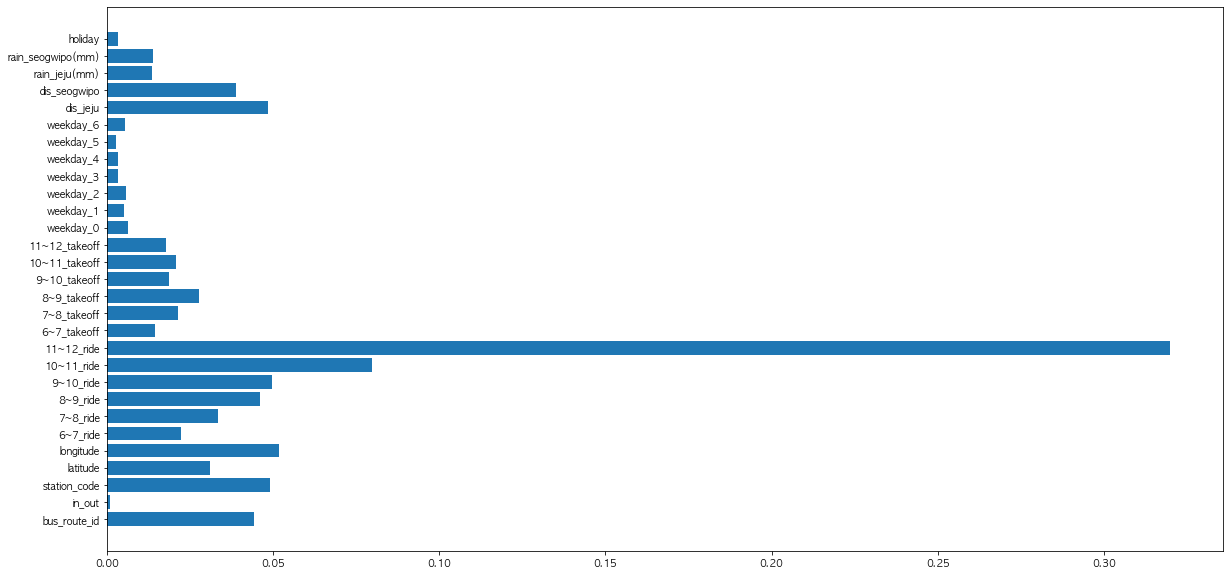

In [18]:
plt.figure(figsize = (20,10))
importances = list(rf.feature_importances_)
x_values = list(range(len(importances)))

plt.barh(X_train.columns, importances)

In [ ]:
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)

TypeError: 'module' object is not subscriptable

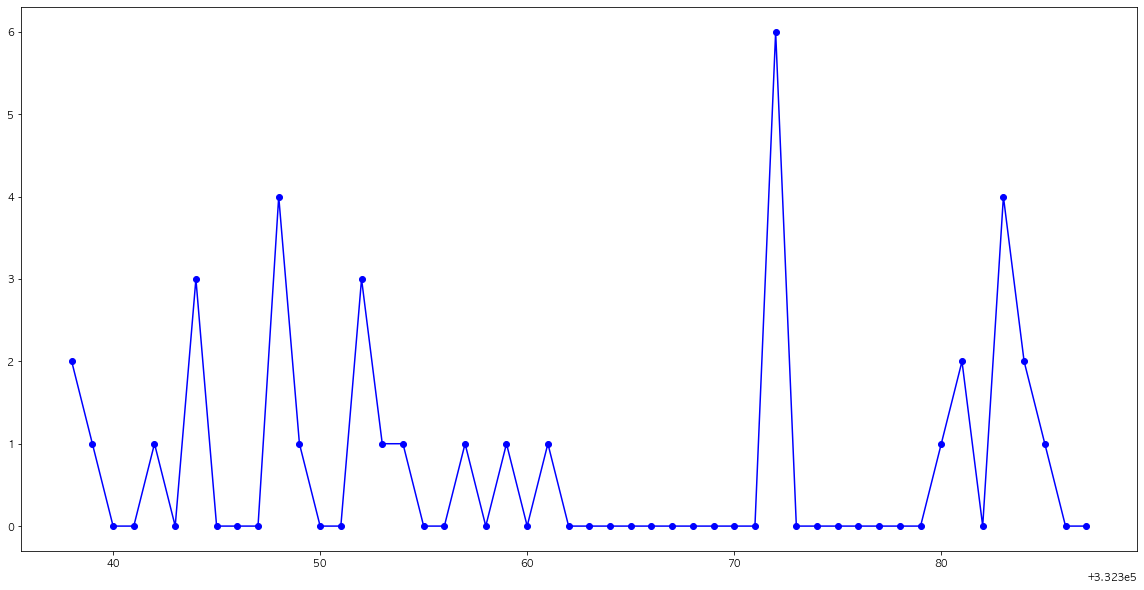

In [14]:
plt.figure(figsize =(20,10))
plt.plot(y_test[:50],marker = 'o', color = 'blue',label = 'real')
plt.plot(xg[:50],marker = '^', color = 'red',label = 'prediction')

In [ ]:
best_model = gridsearch_xgb.best_estimator_
best_pred = best_model.predict(X_test)

plt.figure(figsize =(20,10))
plt.plot(y_test[:50],marker = 'o', color = 'blue',label = 'real')
plt.plot(best_pred[:50],marker = '^', color = 'red',label = 'prediction')

## RandomFoerstRegressor (GridSearchCV)

In [ ]:
rf_params = {'n_estimators' : [100, 120, 140]}
rnd_forest = RandomForestRegressor(random_state=42)

gridsearch_forest = GridSearchCV(rnd_forest, rf_params, scoring=rmse_scorer, cv=5, n_jobs=-1)

%time gridsearch_forest.fit(X_train, y_train)

In [ ]:
gridsearch_forest.best_params_

In [ ]:
cvres = gridsearch_forest.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

In [ ]:
sorted(zip(gridsearch_forest.best_estimator_.feature_importances_, X_train.columns), reverse=True)

## Gradient Boosting

In [12]:
gbrt_params = { 'learning_rate' : [0.01, 0.02, 0.03, 0.04], # 각 트리의 기여도
               'n_estimators' : [1000, 1500],
               'subsample' : [0.9, 0.5, 0.2],
               'max_depth' : [2, 4, 6, 8]
    
}

gbrt = GradientBoostingRegressor()

gridsearch_gbrt = GridSearchCV(gbrt, gbrt_params, scoring=rmse_scorer, cv=5, n_jobs=-1)

In [ ]:
%time gridsearch_gbrt.fit(X_train, y_train)

In [ ]:
gridsearch_gbrt.best_params_

In [ ]:
cvres = gridsearch_gbrt.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

In [ ]:
sorted(zip(gridsearch_gbrt.best_estimator_.feature_importances_, X_train.columns), reverse=True)

In [ ]:
gridsearch_best_model = gridsearch_gbrt.best_estimator_

In [ ]:
scores = cross_val_score(gridsearch_best_model, X_train, y_train, scoring=rmse_scorer, cv=5)
-scores.mean() # 5개 교차 검증한 결과의 평균 rmse

## XGboost

In [21]:
xgb_params = { 'learning_rate' : [0.01, 0.02, 0.03, 0.04], # 각 트리의 기여도
               'n_estimators' : [1000, 1500],
               'subsample' : [0.9, 0.5, 0.2],
               'max_depth' : [2, 4, 6, 8]
    
}

xgb = xg.XGBRegressor()

gridsearch_xgb = GridSearchCV(xgb, xgb_params, scoring=rmse_scorer, cv=5, n_jobs=-1)

In [22]:
%time gridsearch_xgb.fit(X_train, y_train)

In [ ]:
gridsearch_xgb.best_params_

In [ ]:
cvres = gridsearch_xgb.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

In [ ]:
sorted(zip(gridsearch_xgb.best_estimator_.feature_importances_, X_train.columns), reverse=True)

In [ ]:
xgb_best_model = gridsearch_xgb.best_estimator_

In [ ]:
scores = cross_val_score(xgb_best_model, X_train, y_train, scoring=rmse_scorer, cv=5)
-scores.mean() # 5개 교차 검증한 결과의 평균 rmse

# 3.모델 예측 & 평가

## 최종 train/test data 불러오기

In [13]:
train = pd.read_csv(path + 'train_final.csv')
test = pd.read_csv(path + 'test_final.csv')

def holiday(x):
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        return 0

train['holiday'] = train['date'].apply(holiday) 
test['holiday'] = test['date'].apply(holiday) 

In [14]:
train.drop(['date','station_name'], axis=1, inplace=True)
test.drop(['date','station_name'], axis=1, inplace=True)

In [15]:
X_train = train.loc[:, train.columns != '18~20_ride']
y_train=train['18~20_ride']

X_test = test.loc[:, test.columns != '18~20_ride']

## 최종 train & predict

In [16]:
rf_params = {'n_estimators' : [100, 120, 140]}
rnd_forest = RandomForestRegressor(random_state=42)

gridsearch_forest = GridSearchCV(rnd_forest, rf_params, scoring=rmse_scorer, cv=5, n_jobs=-1)

%time gridsearch_forest.fit(X_train, y_train)

CPU times: user 10min 41s, sys: 4.22 s, total: 10min 46s
Wall time: 44min 59s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 120, 140]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [17]:
cvres = gridsearch_forest.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

2.9989209150982843 {'n_estimators': 100}
2.999519501887069 {'n_estimators': 120}
2.997570348936464 {'n_estimators': 140}


In [18]:
best_model = gridsearch_forest.best_estimator_

In [19]:
best_pred = best_model.predict(X_test)
best_pred

array([ 9.85      , 10.11428571,  5.45      , ...,  0.        ,
        0.23571429,  0.04285714])

In [20]:
test['18~20_ride'] = best_pred
test[['id','18~20_ride']].to_csv("dacon_base_line.csv",index=False)